# Data cleaning 

This script:

* extracts the reviews from each file in the data directory (default: "./data/raw_data/movie_reviews")
* cleans up data in each file:
  * convert critics_pick to a boolean type
  * remove unwanted columns ('link' and 'multimedia')
  * replaces opening dates of '0000-00-00' with None
  * convert date columns to datetime type
  * cleans up some obvious Byline errors
  * creates year and month columns, populated first from opening_date and then from publication_date
  * adds "Not Rated" to movies that are missing an MPAA rating
  * remove newlines and carriage returns from the summary
* combines them into a single data frame
* saves the combined data frame to the output file (default: "./data/cleaned_data/movie_reviews.csv").

In [1]:
# Import modules needed
import numpy as np
import pandas as pd
import json
import os

import seaborn as sns
sns.set(style='white',color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

# Path to the data directory into which downloaded JSON is saved.
data_path = os.path.join(".", "data", "raw_data", "movie_reviews")
print(data_path)

# check if path doesn't exists, if not create directory
if not os.path.exists(data_path):
    print("Creating data directory: {}".format(data_path))
    os.makedirs(data_path)

if os.path.isdir(data_path):
    print(data_path + " is a directory")
else:
    print(data_path + " is NOT a directory - something is wrong :(")

    
# Path to the output directory.
csv_file_path = os.path.join(".", "data", "cleaned_data", "movie_reviews.csv")

.\data\raw_data\movie_reviews
.\data\raw_data\movie_reviews is a directory


In [2]:
# Utility function to get the list of raw data JSON file paths.
#
# d - directory to search in
# suffix - only return files ending with this suffix, defaults to ".json"
# returns a list of files 
def get_raw_json_file_paths(d, suffix='.json'):
    
    filelist = [f for f in os.listdir(d) if 
                os.path.isfile(os.path.join(d, f)) and f.endswith(suffix)]
    
    return filelist

In [3]:
# Utility function to restore the datetime type to date columns.
#
# df - dataframe to adjust
# returns dataframe with date columns as datetime types
def process_date_columns(df):
    # Convert dates from object/string into datetime.
    df['publication_date'] = pd.to_datetime(df['publication_date'])
    df['date_updated'] = pd.to_datetime(df['date_updated'])

    # opening_date has some 'interesting' data (e.g. 1998-00-00).

    # Clean up any dates with the value "0000-00-00".
    df.loc[df['opening_date'] == "0000-00-00", ['opening_date']] = None
    
    # Create columns containing the movie's year and month.
    df['movie_year'] = None
    df['movie_month'] = None
    df['movie_month_name'] = None

    # There are 13 entries here - we map any '0' months to January.
    month_names = ['Jan', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    for i, row in df.iterrows():

        year = ""
        month = ""
        
        if str == type(row['opening_date']):
            # Use opening date.
            if str(row['opening_date']).strip().endswith("00-00"):
                # Use publication date, opening date is bad.
                year = str(row['publication_date'])[:4]
                month = str(row['publication_date'])[5:7]

            else:
                # Use opening date.
                year = str(row['opening_date'])[:4]
                month = str(row['opening_date'])[5:7]

        else:
            # Otherwise use publication date.
            year = str(row['publication_date'])[:4]
            month = str(row['publication_date'])[5:7]

        # Clean up months that have the value '0'.
        if (0 == len(month)) or (0 == int(month)):
            month = "1"
            
        df.loc[i, 'movie_year'] = int(year)
        df.loc[i, 'movie_month'] = int(month)

        # Convert month ordinals to names.
        df.loc[i, 'movie_month_name'] = month_names[int(month)]
    
    return df
    

# Function to create a dataframe from a raw data file.
#
# The raw data file includes metadata from the server; this is excluded from the dataframe.
#
# f - path to raw data file
# returns dataframe created from results in raw data file
def create_data_frame(f, verbose=False):
    if verbose:
        print("create_data_frame() - filename: {}".format(f))
    
    # Read the object.
    reviews = None
    with open(f, "rt", encoding="UTF-8") as json_data:
        reviews = json.load(json_data)
        if verbose:
            print(reviews)

    reviews = reviews['results']
    if verbose:
        print(reviews)
    
    # Turn it into a data frame.
    result = pd.DataFrame(reviews)
    if verbose:
        print(result.shape)
        print(result.head(20))

    
    # Convert critics_pick from float to boolean.
    result['critics_pick'] = result['critics_pick'].astype(bool)

    # Columns without an MPAA rating can be filled with 'Not Rated'.
    # The NYT API is inconsistent here, where other columns return null this one has an empty string :(
    result.loc[result['mpaa_rating'] == "", 'mpaa_rating'] = "Not Rated"
    
    # Punctuation is inconsistent in this field, so remove it.
    result['byline'] = result['byline'].str.replace('.', ' ')
    result['byline'] = result['byline'].str.replace('-', ' ')
    result['byline'] = result['byline'].str.replace('_', ' ')
    result['byline'] = result['byline'].str.replace('%', ' ')
    result['byline'] = result['byline'].str.replace(':', ' ')
    result['byline'] = result['byline'].str.replace(']', ' ')
    result['byline'] = result['byline'].str.replace('[', ' ')

    # Some bylines end with a comma; remove it.
    result.loc[result['byline'].str.endswith(','), ['byline']] = result['byline'].str[:-1]
    
    # Collapse runs of whitespace.
    result['byline'] = result['byline'].str.replace('    ', ' ')
    result['byline'] = result['byline'].str.replace('   ', ' ')
    result['byline'] = result['byline'].str.replace('  ', ' ')

    # Remove leading and trailing whitespace.
    result['byline'] = result['byline'].str.strip()

    # Bylines are mixed case, so convert to title case.
    result['byline'] = result['byline'].str.title()

    # These poor fellows have their names misspelled terribly.
    result.loc[result['byline'] == "Moroaunt Hall", ['byline']] = "Mordaunt Hall"
    result.loc[result['byline'] == "Mokdaunt Hall", ['byline']] = "Mordaunt Hall"
    result.loc[result['byline'] == "Modaunt Hall", ['byline']] = "Mordaunt Hall"
    result.loc[result['byline'] == "Modaut Hall", ['byline']] = "Mordaunt Hall"
    result.loc[result['byline'] == "Mordaut Hall", ['byline']] = "Mordaunt Hall"

    result.loc[result['byline'] == "Bosuey Crowther", ['byline']] = "Bosley Crowther"
    result.loc[result['byline'] == "Bossley Crowther", ['byline']] = "Bosley Crowther"
    result.loc[result['byline'] == "Bosley Chowther", ['byline']] = "Bosley Crowther"
    
    result.loc[result['byline'] == "Andrbe Sennwald", ['byline']] = "Andre Sennwald"
    result.loc[result['byline'] == "Andre Senn Wald", ['byline']] = "Andre Sennwald"

    
    # Some summaries end in newline characters, some contain carriage returns and newlines.
    result['summary_short'] = result['summary_short'].str.strip()
    result['summary_short'] = result['summary_short'].str.replace('\r', '')
    result['summary_short'] = result['summary_short'].str.replace('\n', '')

    
    # Convert dates from object/string into datetime.
    result = process_date_columns(result)
    
    # Drop link (URL to full review) and multimedia (image) since we don't care about those.
    return result.drop(['link', 'multimedia'], axis=1)

In [4]:
# Function to create a combined CSV file from a list of dataframes
#
# df_list - list of dataframes to combine and write
# outfilepath - path to the CSV file to write
# returns - the combined dataframe
def create_combined_csv(df_list, outfilepath):
    
    combined_df = pd.concat(df_list)
    print(combined_df.shape)
    
    # QUOTE_NONNUMERIC (2) because we expect commas to be present in text fields.
    combined_df.to_csv(outfilepath, index=False, quoting=2, encoding="UTF-8")
    return combined_df

In [5]:
# call functions to create dataframe
raw_data_file_names = get_raw_json_file_paths(data_path)
dataframes = [create_data_frame(os.path.join(data_path, f), verbose=False) for f in raw_data_file_names]
print("Loaded {} dataframes".format(len(dataframes)))

Loaded 1345 dataframes


In [6]:
# Write the combined CSV file.
combined_df = create_combined_csv(dataframes, csv_file_path)

(26893, 12)


# Data exploration

In [7]:
# And read it back combined CSV file into dataframe
restored_df = pd.read_csv(csv_file_path, quoting=2, parse_dates=True, infer_datetime_format=True, encoding="UTF-8")
restored_df = process_date_columns(restored_df)

# explore the dataframe
print(restored_df.shape)
print(restored_df.info())
print(restored_df.head(10))

(26893, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26893 entries, 0 to 26892
Data columns (total 12 columns):
byline              26893 non-null object
critics_pick        26893 non-null bool
date_updated        26878 non-null datetime64[ns]
display_title       26893 non-null object
headline            26893 non-null object
mpaa_rating         26893 non-null object
opening_date        16971 non-null object
publication_date    26893 non-null datetime64[ns]
summary_short       20764 non-null object
movie_year          26893 non-null object
movie_month         26893 non-null object
movie_month_name    26893 non-null object
dtypes: bool(1), datetime64[ns](2), object(9)
memory usage: 2.3+ MB
None
                byline critics_pick        date_updated  \
0       Manohla Dargis         True 2017-04-18 16:44:22   
1            A O Scott         True 2017-04-18 16:44:21   
2            A O Scott         True 2017-04-18 16:44:21   
3  Jeannette Catsoulis        False 2017-04-18 16:44

In [8]:
# see colmns of a dataframe
print(restored_df.columns)

Index(['byline', 'critics_pick', 'date_updated', 'display_title', 'headline',
       'mpaa_rating', 'opening_date', 'publication_date', 'summary_short',
       'movie_year', 'movie_month', 'movie_month_name'],
      dtype='object')


In [9]:
# describe the dataframe
print(restored_df.describe())

                 byline critics_pick         date_updated display_title  \
count             26893        26893                26878         26893   
unique              301            2                 3359         25744   
top     Bosley Crowther        False  2016-09-23 12:44:01        Hamlet   
freq               3022        23766                   16             7   
first               NaN          NaN  2016-03-30 06:41:07           NaN   
last                NaN          NaN  2017-04-18 16:44:26           NaN   

        headline mpaa_rating opening_date     publication_date summary_short  \
count      26893       26893        16971                26893         20764   
unique     26656           7         8064                12692         20718   
top     Devotion   Not Rated   2014-01-10  2013-10-17 00:00:00      Routine.   
freq           4       15656           16                   25             6   
first        NaN         NaN          NaN  1915-10-20 00:00:00           N

In [10]:
# display value couns for critics pick, mpaa rating , movie month , movie year
print(restored_df['critics_pick'].value_counts())
#print(restored_df['byline'].value_counts())
print(restored_df['mpaa_rating'].value_counts())
print(restored_df['movie_year'].value_counts())
print(restored_df['movie_month'].value_counts())
print(restored_df['movie_month_name'].value_counts())
#print(restored_df[restored_df['movie_month'] == 0])

False    23766
True      3127
Name: critics_pick, dtype: int64
Not Rated    15656
R             5948
PG-13         2477
PG            2244
G              482
X               55
NC-17           31
Name: mpaa_rating, dtype: int64
2014    886
2013    812
2015    783
2016    771
2011    700
2012    691
2007    605
2008    604
2009    581
2010    575
2002    465
2000    432
1998    427
2003    420
2006    419
2001    412
1997    411
1936    402
1999    400
1996    370
1995    368
1934    364
1988    362
1933    360
1987    353
1932    351
1993    347
1986    346
1994    337
1991    336
       ... 
1977    160
1931    157
1950    156
1930    153
1978    152
1975    150
1980    148
1967    142
1957    141
1951    140
1927    138
1929    137
1956    136
1962    129
1963    127
1925    126
1966    114
1926    113
1928    112
1945    104
1937     97
1946     93
1938     89
1924     35
2005     10
1923      2
1921      1
1917      1
1916      1
1915      1
Name: movie_year, dtype: int64
10    277

In [11]:
# check number of null values present in data
print(restored_df.select_dtypes(exclude=[np.number]).isnull().sum())

byline                 0
critics_pick           0
date_updated          15
display_title          0
headline               0
mpaa_rating            0
opening_date        9922
publication_date       0
summary_short       6129
movie_year             0
movie_month            0
movie_month_name       0
dtype: int64


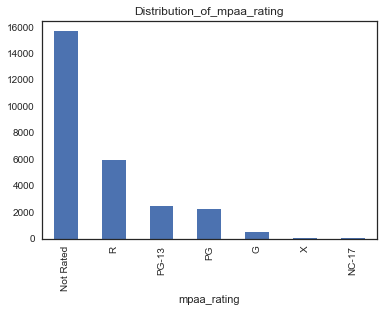

In [14]:
# plot a bar plot for mpaa_rating 
ax = restored_df.groupby('mpaa_rating').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Distribution_of_mpaa_rating')

In [15]:
#Function to create output data folder to store graph and .csv 
def create_directory_for_output():
    current_dir = os.path.dirname('__file__')
    data_folder = os.path.join(current_dir, 'exploratory_analysis')
    if not os.path.exists(data_folder):
        os.mkdir(data_folder)
    return data_folder

output_folder=create_directory_for_output()

In [16]:
# save the plot to output folder
plot_name = 'Distribution_of_mpaa_rating1'
plot_path = os.path.join(output_folder, plot_name)
plot_path+='.png'
ax.figure.savefig(plot_path,bbox_inches='tight')

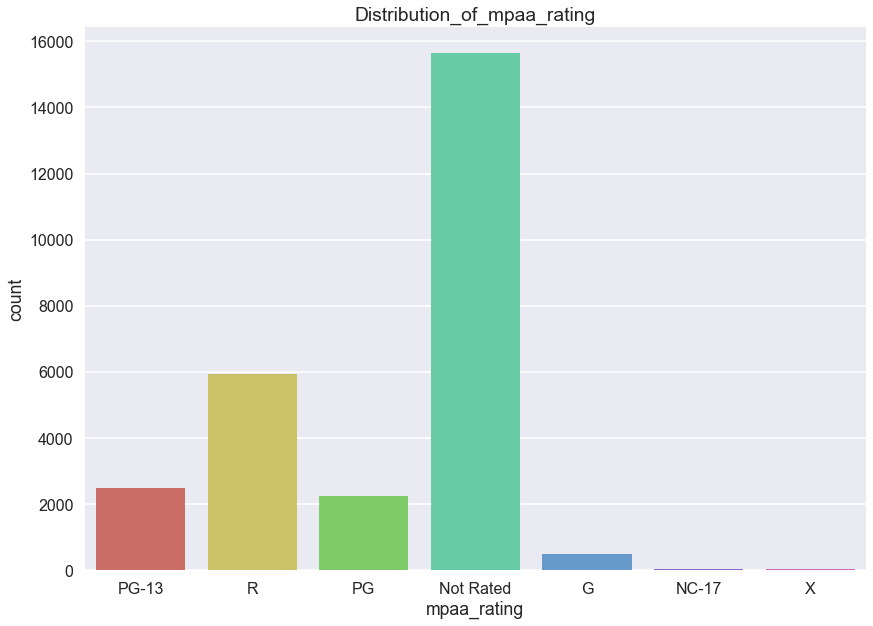

In [20]:
# plot sns countplot for mpaa rating distribution
sns.set_context("poster")
plt.figure(figsize=(14, 10))
ax = sns.countplot(x="mpaa_rating", data=restored_df, palette="hls")
plt.title('Distribution_of_mpaa_rating')

In [21]:
# save the plot to output folder
plot_name = 'Distribution_of_mpaa_rating2'
plot_path = os.path.join(output_folder, plot_name)
plot_path+='.png'
ax.figure.savefig(plot_path,bbox_inches='tight')

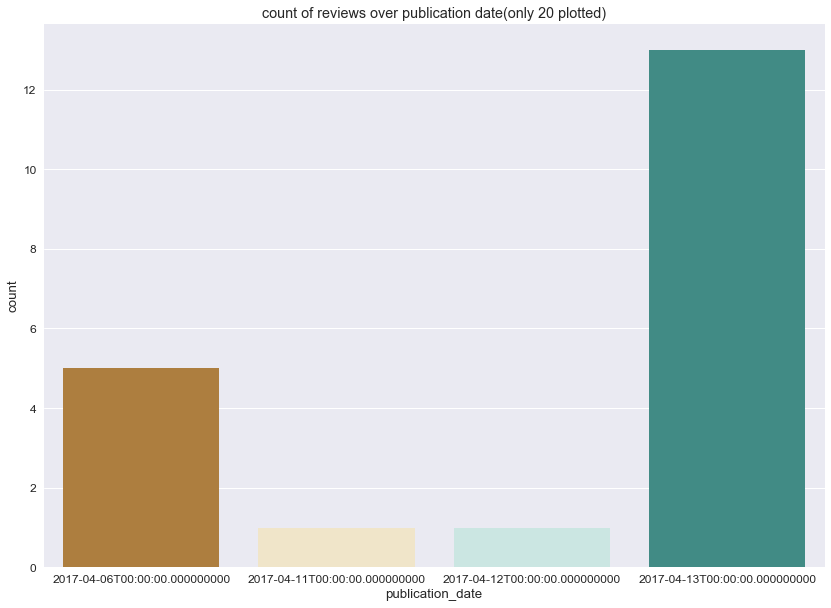

In [30]:
# plot sns countplot for publication date of reviews count
sns.set_context("poster")
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")
sns.set(font_scale=1.2)
ax = sns.countplot(x="publication_date", data=restored_df[:20], palette="BrBG")
plt.title('count of reviews over publication date(only 20 plotted)')

In [31]:
# save the plot to output folder
plot_name = 'Review_count_pubicationdates'
plot_path = os.path.join(output_folder, plot_name)
plot_path+='.png'
ax.figure.savefig(plot_path,bbox_inches='tight')

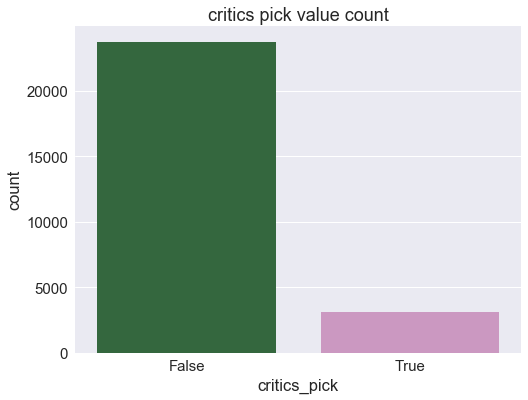

In [34]:
# plot the sns plot for critics value
sns.set_context("paper")
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.5)
ax = sns.countplot(x="critics_pick", data=restored_df, palette="cubehelix")
plt.title("critics pick value count")

In [35]:
# save the plot to output folder
plot_name = 'critic_pick_value_count'
plot_path = os.path.join(output_folder, plot_name)
plot_path+='.png'
ax.figure.savefig(plot_path,bbox_inches='tight')